Import librerie

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, kendalltau
import yfinance as yf
import requests
import os
from io import StringIO

# Importa i metodi MCDM da pymcdm
from pymcdm.methods import TOPSIS, VIKOR, PROMETHEE_II

Download e preprocessing dei dati

In [7]:
filename = "sp500_data.csv"
if os.path.exists(filename):
    print(f"File {filename} trovato, non lo scarico di nuovo.")
else:
    print("🔄 File non trovato, scarico i dati...")

    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    tables = pd.read_html(StringIO(requests.get(url).text))
    sp500 = tables[0]
    tickers = [symbol.replace(".", "-") for symbol in sp500["Symbol"].tolist()]
    valid_tickers = []
    data = {}

    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(period='1y')
            if hist.empty:
                print(f"⚠️ No data for {ticker}, skipping...")
                continue
            info = stock.info
            data[ticker] = {
                "MarketCap": info.get("marketCap", np.nan),
                "Momentum_6m": hist["Close"].pct_change(min(len(hist), 126)).iloc[-1] if len(hist) > 126 else np.nan,
                "Volatility": hist["Close"].pct_change().std() * (252 ** 0.5),
                "Return_6m": hist["Close"].pct_change(min(len(hist), 126)).iloc[-1] if len(hist) > 126 else np.nan,
            }
            valid_tickers.append(ticker)
        except Exception as e:
            print(f"⚠️ Error processing {ticker}: {e}, skipping...")
            continue

    df = pd.DataFrame.from_dict(data, orient="index")
    df.dropna(inplace=True)
    df.to_csv(filename)
    print(f"✅ Dati salvati in '{filename}' per {len(valid_tickers)} aziende su {len(tickers)} disponibili.")
    
    df = pd.read_csv(filename, index_col=0)
    print("Matrice di valutazione, solo le prime 10:")
    print(df.head(10))

File sp500_data.csv trovato, non lo scarico di nuovo.


Definizione Pesi, Tipi, e Metodi MCDM

In [9]:
df = pd.read_csv(filename, index_col=0)
print("Matrice di valutazione, solo le prime 10:")
print(df.head(10))
weights = np.array([0.1, 0.3, 0.4, 0.2])
types = np.array([1, 1, -1, 1])
TOP_N = 20

topsis = TOPSIS()
vikor = VIKOR(v=0.5)
promethee = PROMETHEE_II(preference_function='usual')

matrix = df.values
norm_matrix = df / np.linalg.norm(matrix, axis=0)

pref_topsis = topsis(norm_matrix, weights, types)
rank_topsis = topsis.rank(pref_topsis)

pref_vikor = vikor(norm_matrix, weights, types)
rank_vikor = vikor.rank(pref_vikor)

pref_promethee = promethee(norm_matrix.astype(float), weights.astype(float), types.astype(float))
rank_promethee = promethee.rank(pref_promethee)

results = pd.DataFrame({
    'Alternative': [f'Alt_{i+1}' for i in range(df.shape[0])],
    'Score_TOPSIS': pref_topsis,
    'Rank_TOPSIS': rank_topsis,
    'Score_VIKOR': pref_vikor,
    'Rank_VIKOR': rank_vikor,
    'Score_PROMETHEE': pref_promethee,
    'Rank_PROMETHEE': rank_promethee
})
print(results.head())

Matrice di valutazione, solo le prime 10:
         MarketCap  Momentum_6m  Volatility  Return_6m
MMM    74742587392     0.053149    0.359214   0.053149
AOS     9372467200    -0.161056    0.252993  -0.161056
ABT   224387121152     0.120618    0.206596   0.120618
ABBV  329136406528     0.004187    0.268825   0.004187
ACN   183669768192    -0.203588    0.268023  -0.203588
ADBE  156722266112    -0.254284    0.371856  -0.254284
AMD   157012361216    -0.372769    0.535814  -0.372769
AES     7204513792    -0.393077    0.430028  -0.393077
AFL    59570253824    -0.027867    0.219987  -0.027867
A      30511712256    -0.200490    0.296197  -0.200490
  Alternative  Score_TOPSIS  Rank_TOPSIS  Score_VIKOR  Rank_VIKOR  \
0       Alt_1      0.523629        268.0     0.337767       179.0   
1       Alt_2      0.527848        253.0     0.405908       330.0   
2       Alt_3      0.587459         33.0     0.250894        43.0   
3       Alt_4      0.550432        148.0     0.324226       151.0   
4       

Top N Classifica

In [11]:
print(f"--- Top {TOP_N} Ranking ---")

print("\nTOPSIS:")
print(results.sort_values('Rank_TOPSIS').head(TOP_N)[['Alternative', 'Rank_TOPSIS', 'Score_TOPSIS']])

print("\nVIKOR:")
print(results.sort_values('Rank_VIKOR').head(TOP_N)[['Alternative', 'Rank_VIKOR', 'Score_VIKOR']])

print("\nPROMETHEE II:")
print(results.sort_values('Rank_PROMETHEE').head(TOP_N)[['Alternative', 'Rank_PROMETHEE', 'Score_PROMETHEE']])

--- Top 20 Ranking ---

TOPSIS:
    Alternative  Rank_TOPSIS  Score_TOPSIS
468     Alt_469          1.0      0.642905
94       Alt_95          2.0      0.616848
371     Alt_372          3.0      0.612747
308     Alt_309          4.0      0.612558
433     Alt_434          5.0      0.612142
333     Alt_334          6.0      0.612091
360     Alt_361          7.0      0.612045
110     Alt_111          8.0      0.611453
47       Alt_48          9.0      0.608561
92       Alt_93         10.0      0.607453
397     Alt_398         11.0      0.606800
21       Alt_22         12.0      0.606586
60       Alt_61         13.0      0.605922
84       Alt_85         14.0      0.601747
279     Alt_280         15.0      0.601624
179     Alt_180         16.0      0.598803
474     Alt_475         17.0      0.598602
434     Alt_435         18.0      0.598234
181     Alt_182         19.0      0.596441
48       Alt_49         20.0      0.596377

VIKOR:
    Alternative  Rank_VIKOR  Score_VIKOR
468     Alt_469 

Correlazione tra i ranking

In [13]:
print("--- Correlazione tra Ranking ---")
spearman_topsis_vikor, _ = spearmanr(results['Rank_TOPSIS'], results['Rank_VIKOR'])
kendall_topsis_vikor, _ = kendalltau(results['Rank_TOPSIS'], results['Rank_VIKOR'])
print(f"TOPSIS vs VIKOR: Spearman Rho = {spearman_topsis_vikor:.4f}, Kendall Tau = {kendall_topsis_vikor:.4f}")

spearman_topsis_promethee, _ = spearmanr(results['Rank_TOPSIS'], results['Rank_PROMETHEE'])
kendall_topsis_promethee, _ = kendalltau(results['Rank_TOPSIS'], results['Rank_PROMETHEE'])
print(f"TOPSIS vs PROMETHEE II: Spearman Rho = {spearman_topsis_promethee:.4f}, Kendall Tau = {kendall_topsis_promethee:.4f}")

spearman_vikor_promethee, _ = spearmanr(results['Rank_VIKOR'], results['Rank_PROMETHEE'])
kendall_vikor_promethee, _ = kendalltau(results['Rank_VIKOR'], results['Rank_PROMETHEE'])
print(f"VIKOR vs PROMETHEE II: Spearman Rho = {spearman_vikor_promethee:.4f}, Kendall Tau = {kendall_vikor_promethee:.4f}")


--- Correlazione tra Ranking ---
TOPSIS vs VIKOR: Spearman Rho = 0.8908, Kendall Tau = 0.7439
TOPSIS vs PROMETHEE II: Spearman Rho = 0.9421, Kendall Tau = 0.8182
VIKOR vs PROMETHEE II: Spearman Rho = 0.9506, Kendall Tau = 0.8231


Heatmap della correlazione tra ranking

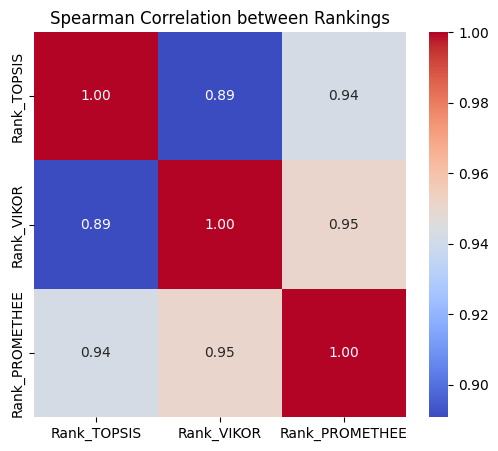

In [15]:
corr_matrix = results[['Rank_TOPSIS', 'Rank_VIKOR', 'Rank_PROMETHEE']].corr(method='spearman')

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Spearman Correlation between Rankings')
plt.show()

Scatter plot dei punteggi

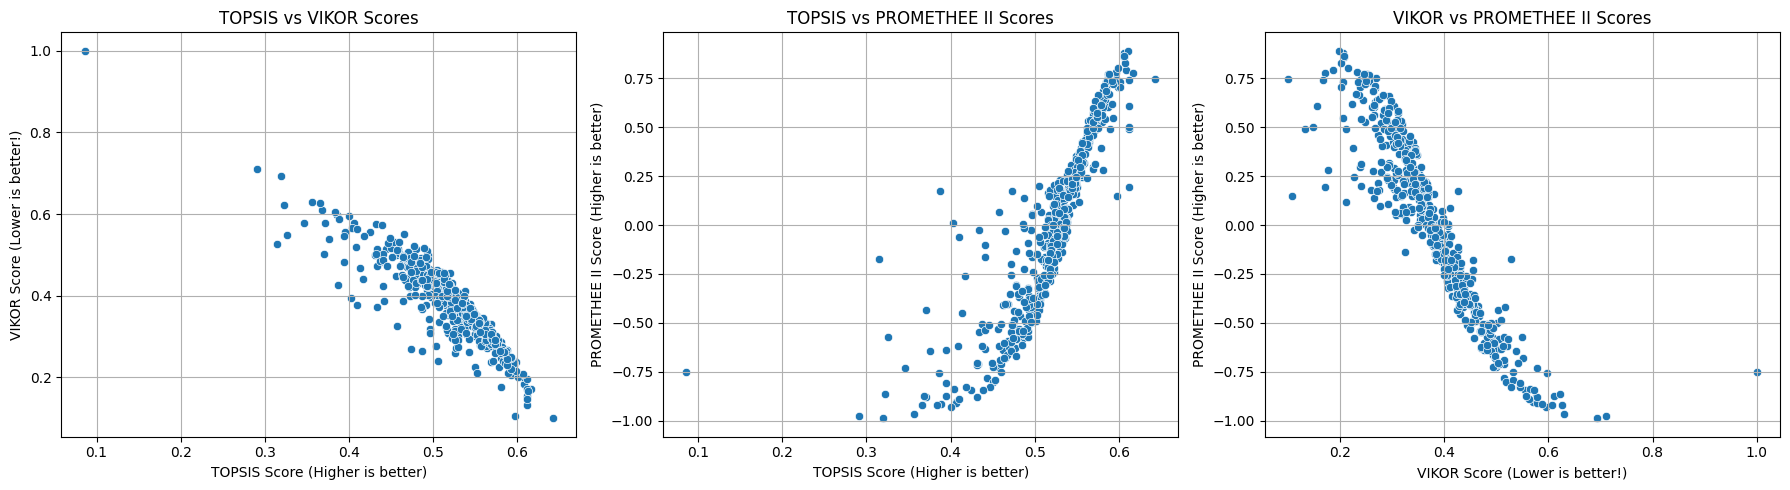

In [17]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(data=results, x='Score_TOPSIS', y='Score_VIKOR')
plt.title('TOPSIS vs VIKOR Scores')
plt.xlabel('TOPSIS Score (Higher is better)')
plt.ylabel('VIKOR Score (Lower is better!)')
plt.grid(True)

plt.subplot(1, 3, 2)
sns.scatterplot(data=results, x='Score_TOPSIS', y='Score_PROMETHEE')
plt.title('TOPSIS vs PROMETHEE II Scores')
plt.xlabel('TOPSIS Score (Higher is better)')
plt.ylabel('PROMETHEE II Score (Higher is better)')
plt.grid(True)

plt.subplot(1, 3, 3)
sns.scatterplot(data=results, x='Score_VIKOR', y='Score_PROMETHEE')
plt.title('VIKOR vs PROMETHEE II Scores')
plt.xlabel('VIKOR Score (Lower is better!)')
plt.ylabel('PROMETHEE II Score (Higher is better)')
plt.grid(True)

plt.tight_layout()
plt.show()

Analisi di sensibilità

In [19]:
print("--- Analisi di Sensibilità (Variazione Pesi) ---")

rank_topsis_orig = results['Rank_TOPSIS'].copy()
rank_vikor_orig = results['Rank_VIKOR'].copy()
rank_promethee_orig = results['Rank_PROMETHEE'].copy()

weights_scen2 = weights.copy()
delta = 0.05
weights_scen2[0] += delta
weights_scen2[1] -= delta
weights_scen2 = np.clip(weights_scen2, 0.01, 0.99)
weights_scen2 = weights_scen2 / np.sum(weights_scen2)

print(f"Scenario Sensibilità: Pesi = {weights_scen2}")

pref_topsis_s2 = topsis(matrix, weights_scen2, types)
rank_topsis_s2 = topsis.rank(pref_topsis_s2)

pref_vikor_s2 = vikor(matrix, weights_scen2, types)
rank_vikor_s2 = vikor.rank(pref_vikor_s2)

pref_promethee_s2 = promethee(matrix.astype(float), weights_scen2.astype(float), types.astype(float))
rank_promethee_s2 = promethee.rank(pref_promethee_s2)

stab_topsis, _ = spearmanr(rank_topsis_orig, rank_topsis_s2)
stab_vikor, _ = spearmanr(rank_vikor_orig, rank_vikor_s2)
stab_promethee, _ = spearmanr(rank_promethee_orig, rank_promethee_s2)

print(f"\nStabilità Ranking (Spearman Rho con ranking originale):")
print(f"TOPSIS: {stab_topsis:.4f}")
print(f"VIKOR: {stab_vikor:.4f}")
print(f"PROMETHEE II: {stab_promethee:.4f}")

--- Analisi di Sensibilità (Variazione Pesi) ---
Scenario Sensibilità: Pesi = [0.15 0.25 0.4  0.2 ]

Stabilità Ranking (Spearman Rho con ranking originale):
TOPSIS: 0.9927
VIKOR: 0.9934
PROMETHEE II: 0.9966


Benchmark Tempi di Esecuzione

In [21]:
import time

def benchmark_method(method, matrix, weights, types, repeats=5):
    times = []
    for _ in range(repeats):
        start = time.time()
        _ = method(matrix, weights, types)
        end = time.time()
        times.append(end - start)
    return np.mean(times) * 1000

time_topsis = benchmark_method(topsis, norm_matrix, weights, types)
time_vikor = benchmark_method(vikor, norm_matrix, weights, types)
time_promethee = benchmark_method(promethee, norm_matrix.astype(float), weights.astype(float), types.astype(float))

summary_table = pd.DataFrame({
    'Metodo': ['TOPSIS', 'VIKOR', 'PROMETHEE II'],
    'Tempo Medio (ms)': [time_topsis, time_vikor, time_promethee],
    'Spearman Sensibilità (var pesi)': [stab_topsis, stab_vikor, stab_promethee],
})

summary_table = summary_table.sort_values(by='Tempo Medio (ms)')
print(summary_table)

summary_table.to_csv("summary_table_mcdm.csv", index=False)
print("✅ Tabella salvata in 'summary_table_mcdm.csv'")

         Metodo  Tempo Medio (ms)  Spearman Sensibilità (var pesi)
1         VIKOR          5.622959                         0.993427
0        TOPSIS          8.373642                         0.992667
2  PROMETHEE II         11.433983                         0.996570
✅ Tabella salvata in 'summary_table_mcdm.csv'


Bar plot tempi di esecuzione

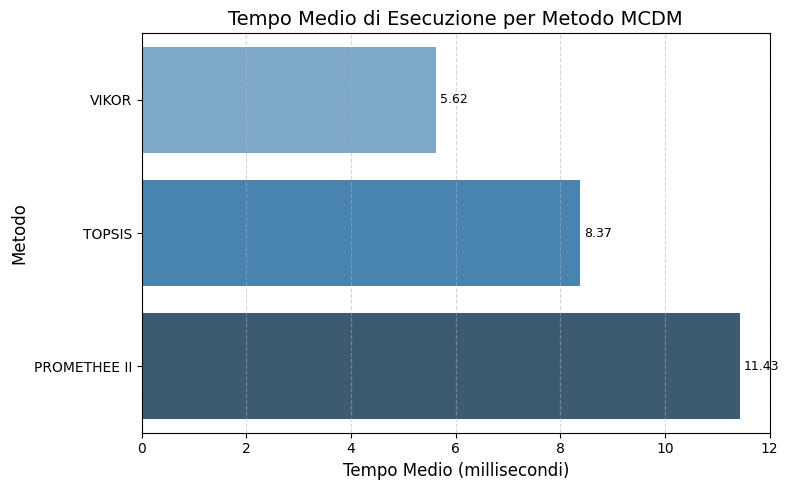

In [24]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x="Tempo Medio (ms)",
    y="Metodo",
    hue="Metodo",
    data=summary_table,
    palette="Blues_d",
    dodge=False,
    legend=False
)

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", padding=3, fontsize=9)

plt.title('Tempo Medio di Esecuzione per Metodo MCDM', fontsize=14)
plt.xlabel('Tempo Medio (millisecondi)', fontsize=12)
plt.ylabel('Metodo', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()